## Setup

Files and system

In [1]:
import os
import json

Arrays and math

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

In [3]:
import random

Geometry

In [4]:
from shapely.geometry import Point, MultiPoint

In [5]:
from shapely.ops import transform as shapely_transform

In [6]:
from shapely import from_wkt

In [7]:
import pyproj

Raster operations

In [8]:
from scipy.ndimage import distance_transform_edt

In [9]:
import rasterio
import rioxarray
from rasterio.features import rasterize

In [10]:
from rasterio.transform import from_origin

Plotting

In [11]:
import matplotlib.pyplot as plt

Logging

In [12]:
import logging
from contextlib import redirect_stdout, redirect_stderr

Directories

In [13]:
DATA_DIR = '../data/'
FIGURES_DIR = '../saved_figures/'

Habitat data

In [14]:
habitats_shp = os.path.join(DATA_DIR, 'OSPARHabitats2022_Points_clustered/OSPAR2022Points.shp')
habitats_gdf = gpd.read_file(habitats_shp)

Sub-tile grid

In [15]:
with open(os.path.join(DATA_DIR, 'tile_buffer_wkt.json'), 'r') as f:
    tiles_wkt_dict = json.load(f)

In [52]:
def sample_pixels_from_mask(mask_da, n_samples, seed=None):
    valid_y, valid_x = np.where(mask_da.values)
    n_samples = min(n_samples, len(valid_x))
    rng = np.random.default_rng(seed)
    sampled_indices = rng.choice(len(valid_x), size=n_samples, replace=False)

    rows = valid_y[sampled_indices]
    cols = valid_x[sampled_indices]

    return rows, cols

Example

In [109]:
sampled_points = sample_pixels_from_mask(background_mask, n_samples=100, seed=42)

In [110]:
sampled_points

(array([ 901, 1259, 1069,  926,  912, 1137,  598,  796,  610, 1098,  628,
         954,  898, 1168,  845, 1086, 1174,  649, 1216, 1289,  680, 1243,
        1220,  572,  605, 1180, 1149,  635, 1125,  583,  694,  999, 1087,
         978,  993,  750, 1230, 1142, 1054, 1130,  540, 1181,  994,  861,
         906,  934, 1045,  518, 1126,  679, 1060, 1224, 1077,  842,  908,
         922, 1247,  967, 1109, 1114,  874,  846, 1134,  526, 1049, 1077,
        1171,  535,  736,  545, 1293, 1124,  491, 1193, 1088,  900, 1193,
         641,  839,  514,  542,  956, 1300,  903,  780, 1155, 1046, 1074,
         928, 1139,  882,  829, 1115,  573, 1079,  801,  538, 1006,  912,
        1175]),
 array([1333,  779,  909,  762,  912,  713, 1355,  878, 1221,  835, 1268,
         761, 1191,  499, 1319,  551, 1075, 1195,  537,  643,  762, 1007,
         576,  929, 1299,  597,  537, 1445,  643,  860,  765, 1321, 1221,
         979,  772,  792,  463,  802,  546,  781, 1200,  933,  689,  866,
        1241,  767, 11

Save

In [ ]:
# sampled_points_gdf = ...

In [ ]:
# sampled_points_gdf.to_file(...

In [53]:
def sample_point_pixels(gdf, coords_tree, n_samples, seed=None):
    n_samples = min(n_samples, len(gdf))
    rng = np.random.default_rng(seed)

    # sample randomly
    sampled_indices = rng.choice(len(gdf), size=n_samples, replace=False)

    # find pixel locations
    geoms = gdf.loc[sampled_indices, 'geometry']
    _, pixel_locs = coords_tree.query(np.column_stack((geoms.values.x, geoms.values.y)))

    return pixel_locs

Example

In [ ]:
hab_of_interest = ['Zostera beds', 'Kelp forests']

In [ ]:
other_gdf = gdf[~gdf['HabType'].isin(hab_of_interest)]

In [ ]:
tile_gdf = other_gdf[other_gdf['tileId'] == tileId]

In [ ]:
subtile_gdf = tile_gdf[tile_gdf['subtile_index'] == subtile_idx]

In [ ]:
latitudes = template_da['lat'].values.ravel()
longitudes = template_da['lon'].values.ravel()

coords_tree = cKDTree(np.column_stack((latitudes, longitudes)))

other_samples = sample_point_pixels(subtile_gdf, coords_tree, 100, seed=42)

## Loop over tiles and subtiles - test: Zostera only

In [58]:
with open(os.path.join(DATA_DIR, 'unknown_subtiles.json'), 'r') as f:
    unknown_subtiles = json.load(f)

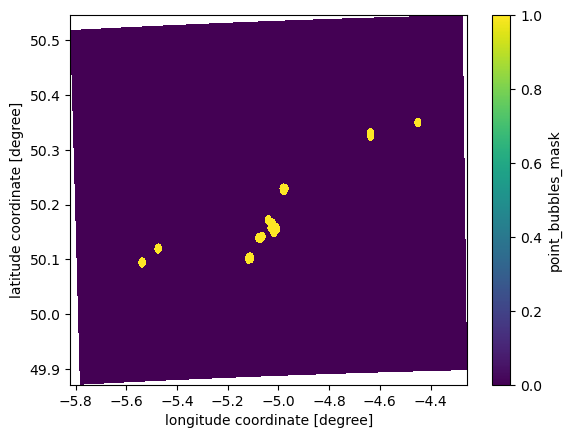

In [56]:
bubbles_mask.plot(x='lon', y='lat')

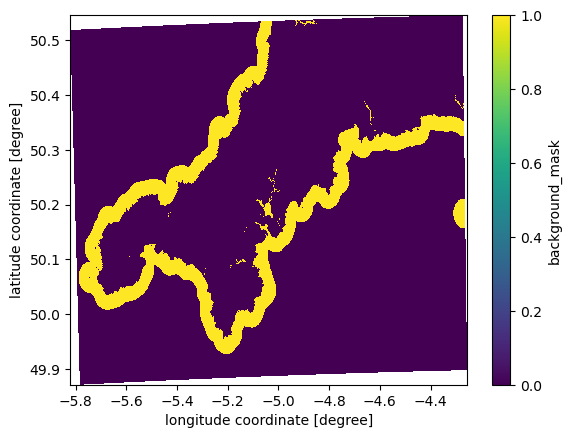

In [57]:
background_mask.plot(x='lon', y='lat')

In [43]:
background_mask

<xarray.DataArray 'background_mask' (y: 3599, x: 5490)> Size: 20MB
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
    lat          (y, x) float64 158MB 50.52 50.52 50.52 50.52 ... 49.9 49.9 49.9
    lon          (y, x) float64 158MB -5.821 -5.821 -5.821 ... -4.256 -4.256
    spatial_ref  int64 8B 0
Dimensions without coordinates: y, x

In [46]:
def rasterize_with_origin(geoms, lon_origin, lat_origin, out_shape, burn_value=1, fill=0, res=20, original_crs="EPSG:4326", metric_crs="EPSG:32630"):
    # Get transform and shape from template raster
    reproj = pyproj.Transformer.from_crs(original_crs, metric_crs, always_xy=True).transform
    x_origin, y_origin = reproj(lon_origin, lat_origin)
    transform = from_origin(x_origin, y_origin, res, res)

    # Rasterize
    raster = rasterize(
        [(shapely_transform(reproj, geom), burn_value) for geom in geoms],
        out_shape=out_shape,
        transform=transform,
        fill=fill,
        dtype='uint8'
    )

    return raster

In [ ]:
log_file = 'background_sampling.log'
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.FileHandler(log_file, mode='a')]
)
logger = logging.getLogger(__name__)

In [76]:
sample_bkg_dicts = []

In [ ]:
for tileId, subtiles in tiles_wkt_dict.items():
    if tileId != '30UUA':
        continue
    
    # Sentinel-2 derivations
    print(f"[{tileId}] Loading Sentinel-2 derivations...")
    idepix_df = os.path.join(DATA_DIR, f's2_processed/{tileId}/idepix-{tileId}.nc')
    idepix_ds = xr.open_dataset(idepix_df)
    polymer_fp = os.path.join(DATA_DIR, f's2_processed/{tileId}/polymer-{tileId}.nc')
    polymer_ds = xr.open_dataset(polymer_fp)

    # Masks
    print(f"[{tileId}] Creating masks...")
    logger.info(f"[{tileId}] Creating masks...")
    polymer_mask = np.isnan(polymer_ds['Rw665'].values)
    template_da = idepix_ds['pixel_classif_flags']
    land_mask = (template_da.astype('int32') & 2**10) != 0
    land_mask = land_mask | polymer_mask
    
    # Coastal buffer
    coastal_buffer_da = coastal_buffer(tileId, land_mask).astype(bool)

    # Habitats dataframe
    tile_habitats_gdf = habitats_gdf[(habitats_gdf['utm_tile'] == tileId) & (habitats_gdf['HabStatus'] == 'Present')]
    target_gdf = tile_habitats_gdf[tile_habitats_gdf['HabType'] == TARGET_HABTYPE]

    # Point bubbles
    bubbles_mask = point_bubbles(target_gdf, template_da).astype(bool)

    # Combined mask
    background_mask = coastal_buffer_da & ~bubbles_mask
    background_mask.name = "background_mask"

    print(f"[{tileId}] Masks created. Sampling background...")
    logger.info(f"[{tileId}] Masks created. Sampling background...")

    for subtile_in, subtile_wkt in enumerate(subtiles):
        if subtile_in in unknown_subtiles[tileId]:  # don't sample from unknown subtiles
            continue
        
        # Setup sampling region
        latitudes = template_da['lat'].values.ravel()
        longitudes = template_da['lon'].values.ravel()
        subtile_geom = from_wkt(subtile_wkt)
        subtile_mask = rasterize_with_origin(
            [subtile_geom],
            longitudes[0],
            latitudes[0],
            template_da.shape
        )

        subtile_bkg_mask = background_mask & subtile_mask

        # Sample background
        sample_background = sample_pixels_from_mask(subtile_bkg_mask, n_samples=N_BACKGROUND, seed=42)
        sample_bkg_dicts.extend([
            {'tileId': tileId, 'subtile_in': subtile_in, 'x': x, 'y': y}
            for y, x in zip(*sample_background)
        ])

        # # Setup sampling from gdf
        # coords_tree = cKDTree(np.column_stack((latitudes, longitudes)))
        # subtile_habitats_gdf = tile_habitats_gdf[tile_habitats_gdf['subtile_in'] == subtile_in]
        # subtile_target_gdf = target_gdf[target_gdf['subtile_in'] == subtile_in]
        # subtile_other_gdf = subtile_habitats_gdf[subtile_habitats_gdf['HabType'] != TARGET_HABTYPE]

        # # Sample other
        # other_samples = sample_point_pixels(subtile_habitats_gdf, coords_tree, n_samples=N_OTHER, seed=42)

        # # Sample target...

    print(f"[{tileId}] Done.")
    logger.info(f"[{tileId}] Done.")

In [74]:
sample_bkg_df = pd.DataFrame.from_dict(sample_bkg_dicts)

In [75]:
sample_bkg_df

,tileId,subtile_in,x,y
0,30UUA,0,310,2756
1,30UUA,0,199,2639
2,30UUA,0,303,2716
3,30UUA,0,140,2531
4,30UUA,0,265,2637


Different approach!! Store rasters of subtiles stacked together to create data cube!

Just save the background masks, labelled by subtile index, as well as habitat point bubble layers.

N_tiles x N_subtiles x (1 + N_habitats) x height x width

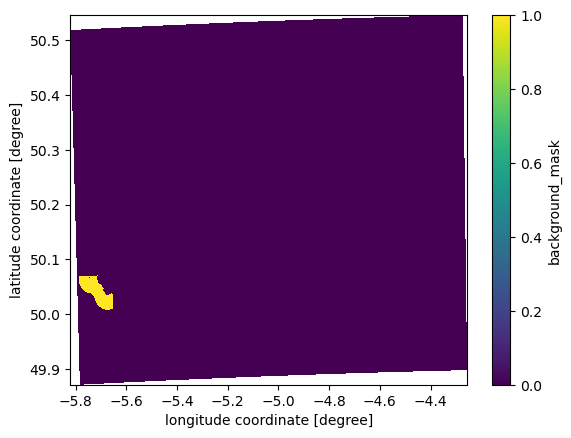

In [51]:
subtile_bkg_mask.plot(x='lon', y='lat')

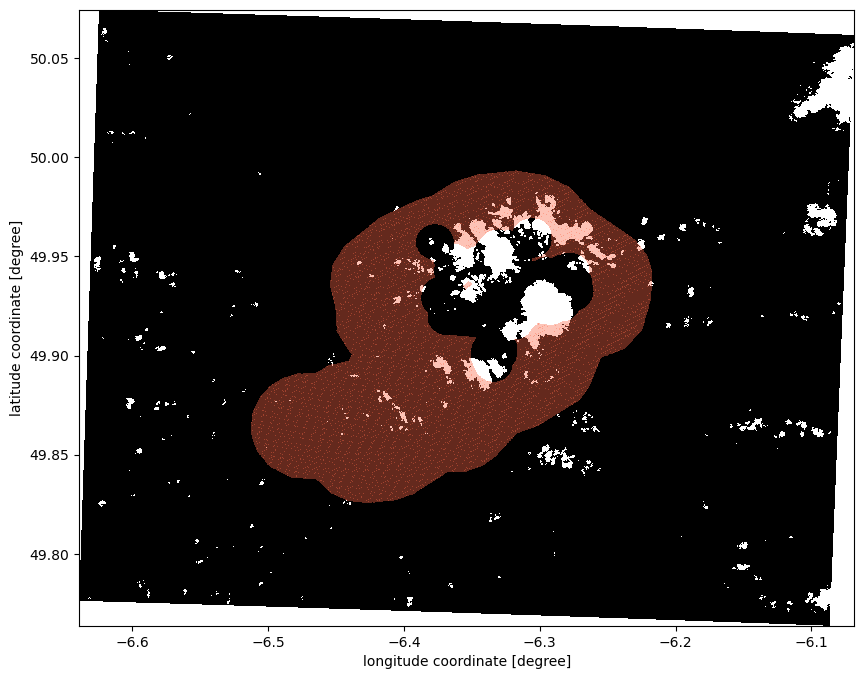

In [100]:
fig, ax = plt.subplots(figsize=(10, 8))
land_mask.plot(ax=ax, x='lon', y='lat', cmap='gray', add_colorbar=False)
background_mask.where(background_mask > 0).plot(
    ax=ax,
    x='lon',
    y='lat',
    cmap='Reds',
    alpha=0.4,
    add_colorbar=False
)